In [1]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.utils import np_utils




data = pd.read_csv("Alzheimer's.csv")

#categorical conversion 
#Converted the group to dummy variables
data.loc[data.Group=='Nondemented', 'Group'] = 0
data.loc[data.Group=='Demented', 'Group'] = 1
data.loc[data.Group=='Converted', 'Group'] = 2

#Converted the M/F to dummy variables
data.loc[data.Sex=='M', 'Sex'] = 0
data.loc[data.Sex=='F', 'Sex'] = 1

#ToDo
#Fill in SES and Mini Mental State missing sample values
#Use the mean of that category for the value
# Get rid of SES data 

data

,Subject ID,MRI ID,Group,Visit,MR Delay,Sex,Hand,Age,EDUC,SES,Mini Mental State,Clinical Dementia Rating,Estimated total Intracranial Volume,Normalize Whole Brain Volume,Atlas Scaling Factor
0,OAS2_0001,OAS2_0001_MR1,0,1,0,0,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,0,2,457,0,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,1,1,0,0,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,1,2,560,0,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,1,3,1895,0,R,80,12,NaN,22.0,0.5,1698,0.701,1.034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,OAS2_0185,OAS2_0185_MR2,1,2,842,0,R,82,16,1.0,28.0,0.5,1693,0.694,1.037
369,OAS2_0185,OAS2_0185_MR3,1,3,2297,0,R,86,16,1.0,26.0,0.5,1688,0.675,1.040
370,OAS2_0186,OAS2_0186_MR1,0,1,0,1,R,61,13,2.0,30.0,0.0,1319,0.801,1.331
371,OAS2_0186,OAS2_0186_MR2,0,2,763,1,R,63,13,2.0,30.0,0.0,1327,0.796,1.323


In [2]:
#Attempting PCA on data
#Hand is completely useless as it is identical for all samples
data_drop = data.drop(['Hand','Visit','Subject ID','MRI ID'], axis = 1) #axis = 1 means to drop column not row

#get rid of row 360 and 359 bc they are missing alot of data (both SES and MMS)
data_drop = data_drop.drop([360, 359])


#delete all data points that dont have SES in them (this is where they have NaN)
data_drop = data_drop.dropna()

#dementia status is what we want to predict - change this to single target 
group = data_drop[['Group']] 



data_drop = data_drop.drop(['Group'], axis = 1) #axis = 1 means to drop column not row






In [3]:
data_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354 entries, 0 to 372
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   MR Delay                             354 non-null    int64  
 1   Sex                                  354 non-null    object 
 2   Age                                  354 non-null    int64  
 3   EDUC                                 354 non-null    int64  
 4   SES                                  354 non-null    float64
 5   Mini Mental State                    354 non-null    float64
 6   Clinical Dementia Rating             354 non-null    float64
 7   Estimated total Intracranial Volume  354 non-null    int64  
 8   Normalize Whole Brain Volume         354 non-null    float64
 9   Atlas Scaling Factor                 354 non-null    float64
dtypes: float64(5), int64(4), object(1)
memory usage: 30.4+ KB


In [4]:
#get a list of columns in pandas object 
names_of_data = data_drop.columns.tolist()

#shuffle = false prevents data split being different everytime
X_train, X_test, y_train, y_test = train_test_split(data_drop, group, test_size=0.2, shuffle = False)

#split train into validate and test, again making sure the data is always the same for consistency
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle = False)

#Normalizing the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_val = sc.transform(X_val)



#running the actual PCA
from sklearn.decomposition import PCA

pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)


y_train = y_train.astype('int').to_numpy().ravel()
y_test = y_test.astype('int').to_numpy().ravel()
y_val = y_val.astype('int').to_numpy().ravel()

y_train = np_utils.to_categorical(y_train, 3)
y_test = np_utils.to_categorical(y_test, 3)
y_val = np_utils.to_categorical(y_val, 3)




In [5]:


#lets use a neural network for this example
from keras.utils import np_utils
from tensorflow.keras.datasets import mnist
import seaborn as sns
from tensorflow.keras.initializers import RandomNormal

%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import time



In [6]:
from keras.layers import Activation, Dense
from keras.models import Sequential 

model = Sequential()
model.add(Dense(10, input_dim=10))
model.add(Activation('relu'))
model.add(Dense(3, input_dim=10))
model.add(Activation('softmax'))

#model.add(Activation('softmax'))
model.compile(optimizer='adam', loss='CategoricalCrossentropy',
             metrics=['accuracy'])

model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                110       
_________________________________________________________________
activation (Activation)      (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 33        
_________________________________________________________________
activation_1 (Activation)    (None, 3)                 0         
Total params: 143
Trainable params: 143
Non-trainable params: 0
_________________________________________________________________


In [7]:
epoch = 400
training = model.fit(X_train, y_train, batch_size=40, epochs=epoch,
                    verbose=1, validation_data=(X_val,y_val))



Epoch 1/400
6/6 [==============================] - 1s 114ms/step - loss: 1.1178 - accuracy: 0.3876 - val_loss: 1.2255 - val_accuracy: 0.3684
Epoch 2/400
6/6 [==============================] - 0s 9ms/step - loss: 1.0868 - accuracy: 0.4921 - val_loss: 1.2143 - val_accuracy: 0.3684
Epoch 3/400
6/6 [==============================] - 0s 9ms/step - loss: 1.1434 - accuracy: 0.4814 - val_loss: 1.2054 - val_accuracy: 0.3860
Epoch 4/400
6/6 [==============================] - 0s 8ms/step - loss: 1.0663 - accuracy: 0.5310 - val_loss: 1.1974 - val_accuracy: 0.3860
Epoch 5/400
6/6 [==============================] - 0s 7ms/step - loss: 1.0448 - accuracy: 0.5343 - val_loss: 1.1910 - val_accuracy: 0.3860
Epoch 6/400
6/6 [==============================] - 0s 7ms/step - loss: 0.9823 - accuracy: 0.5703 - val_loss: 1.1864 - val_accuracy: 0.4035
Epoch 7/400
6/6 [==============================] - 0s 7ms/step - loss: 0.9663 - accuracy: 0.6052 - val_loss: 1.1830 - val_accuracy: 0.4211
Epoch 8/400
6/6 [========

6/6 [==============================] - 0s 7ms/step - loss: 0.3887 - accuracy: 0.9021 - val_loss: 1.5464 - val_accuracy: 0.4386
Epoch 60/400
6/6 [==============================] - 0s 7ms/step - loss: 0.3698 - accuracy: 0.9112 - val_loss: 1.5626 - val_accuracy: 0.4386
Epoch 61/400
6/6 [==============================] - 0s 8ms/step - loss: 0.3767 - accuracy: 0.8987 - val_loss: 1.5764 - val_accuracy: 0.4386
Epoch 62/400
6/6 [==============================] - 0s 7ms/step - loss: 0.3708 - accuracy: 0.9034 - val_loss: 1.5917 - val_accuracy: 0.4386
Epoch 63/400
6/6 [==============================] - 0s 7ms/step - loss: 0.3820 - accuracy: 0.8954 - val_loss: 1.6073 - val_accuracy: 0.4386
Epoch 64/400
6/6 [==============================] - 0s 7ms/step - loss: 0.3660 - accuracy: 0.9011 - val_loss: 1.6219 - val_accuracy: 0.4386
Epoch 65/400
6/6 [==============================] - 0s 7ms/step - loss: 0.3565 - accuracy: 0.9087 - val_loss: 1.6385 - val_accuracy: 0.4386
Epoch 66/400
6/6 [===============

6/6 [==============================] - 0s 7ms/step - loss: 0.2070 - accuracy: 0.9293 - val_loss: 2.3480 - val_accuracy: 0.4561
Epoch 118/400
6/6 [==============================] - 0s 7ms/step - loss: 0.1849 - accuracy: 0.9396 - val_loss: 2.3597 - val_accuracy: 0.4561
Epoch 119/400
6/6 [==============================] - 0s 7ms/step - loss: 0.1907 - accuracy: 0.9389 - val_loss: 2.3718 - val_accuracy: 0.4561
Epoch 120/400
6/6 [==============================] - 0s 7ms/step - loss: 0.1904 - accuracy: 0.9446 - val_loss: 2.3839 - val_accuracy: 0.4561
Epoch 121/400
6/6 [==============================] - 0s 8ms/step - loss: 0.1989 - accuracy: 0.9398 - val_loss: 2.3953 - val_accuracy: 0.4561
Epoch 122/400
6/6 [==============================] - 0s 7ms/step - loss: 0.2107 - accuracy: 0.9359 - val_loss: 2.4062 - val_accuracy: 0.4561
Epoch 123/400
6/6 [==============================] - 0s 7ms/step - loss: 0.2044 - accuracy: 0.9360 - val_loss: 2.4157 - val_accuracy: 0.4561
Epoch 124/400
6/6 [========

6/6 [==============================] - 0s 8ms/step - loss: 0.1308 - accuracy: 0.9605 - val_loss: 2.8421 - val_accuracy: 0.4561
Epoch 176/400
6/6 [==============================] - 0s 8ms/step - loss: 0.1549 - accuracy: 0.9494 - val_loss: 2.8509 - val_accuracy: 0.4386
Epoch 177/400
6/6 [==============================] - 0s 8ms/step - loss: 0.1385 - accuracy: 0.9601 - val_loss: 2.8613 - val_accuracy: 0.4386
Epoch 178/400
6/6 [==============================] - 0s 8ms/step - loss: 0.1289 - accuracy: 0.9592 - val_loss: 2.8697 - val_accuracy: 0.4386
Epoch 179/400
6/6 [==============================] - 0s 8ms/step - loss: 0.1659 - accuracy: 0.9438 - val_loss: 2.8750 - val_accuracy: 0.4386
Epoch 180/400
6/6 [==============================] - 0s 8ms/step - loss: 0.1529 - accuracy: 0.9531 - val_loss: 2.8796 - val_accuracy: 0.4386
Epoch 181/400
6/6 [==============================] - 0s 8ms/step - loss: 0.1377 - accuracy: 0.9542 - val_loss: 2.8837 - val_accuracy: 0.4386
Epoch 182/400
6/6 [========

6/6 [==============================] - 0s 8ms/step - loss: 0.1183 - accuracy: 0.9765 - val_loss: 3.2047 - val_accuracy: 0.4211
Epoch 234/400
6/6 [==============================] - 0s 25ms/step - loss: 0.1120 - accuracy: 0.9746 - val_loss: 3.2079 - val_accuracy: 0.4211
Epoch 235/400
6/6 [==============================] - 0s 9ms/step - loss: 0.1396 - accuracy: 0.9659 - val_loss: 3.2142 - val_accuracy: 0.4211
Epoch 236/400
6/6 [==============================] - 0s 8ms/step - loss: 0.1291 - accuracy: 0.9640 - val_loss: 3.2176 - val_accuracy: 0.4211
Epoch 237/400
6/6 [==============================] - 0s 8ms/step - loss: 0.1189 - accuracy: 0.9762 - val_loss: 3.2235 - val_accuracy: 0.4211
Epoch 238/400
6/6 [==============================] - 0s 8ms/step - loss: 0.1365 - accuracy: 0.9698 - val_loss: 3.2264 - val_accuracy: 0.4211
Epoch 239/400
6/6 [==============================] - 0s 8ms/step - loss: 0.1097 - accuracy: 0.9787 - val_loss: 3.2332 - val_accuracy: 0.4211
Epoch 240/400
6/6 [=======

6/6 [==============================] - 0s 8ms/step - loss: 0.1165 - accuracy: 0.9736 - val_loss: 3.4157 - val_accuracy: 0.4211
Epoch 292/400
6/6 [==============================] - 0s 8ms/step - loss: 0.1137 - accuracy: 0.9753 - val_loss: 3.4126 - val_accuracy: 0.4211
Epoch 293/400
6/6 [==============================] - 0s 8ms/step - loss: 0.1091 - accuracy: 0.9795 - val_loss: 3.4120 - val_accuracy: 0.4211
Epoch 294/400
6/6 [==============================] - 0s 7ms/step - loss: 0.1094 - accuracy: 0.9664 - val_loss: 3.4158 - val_accuracy: 0.4211
Epoch 295/400
6/6 [==============================] - 0s 8ms/step - loss: 0.0971 - accuracy: 0.9816 - val_loss: 3.4202 - val_accuracy: 0.4211
Epoch 296/400
6/6 [==============================] - 0s 8ms/step - loss: 0.1067 - accuracy: 0.9815 - val_loss: 3.4219 - val_accuracy: 0.4211
Epoch 297/400
6/6 [==============================] - 0s 7ms/step - loss: 0.0844 - accuracy: 0.9870 - val_loss: 3.4218 - val_accuracy: 0.4211
Epoch 298/400
6/6 [========

6/6 [==============================] - 0s 8ms/step - loss: 0.0832 - accuracy: 0.9765 - val_loss: 3.5139 - val_accuracy: 0.4211
Epoch 350/400
6/6 [==============================] - 0s 8ms/step - loss: 0.0905 - accuracy: 0.9806 - val_loss: 3.5120 - val_accuracy: 0.4211
Epoch 351/400
6/6 [==============================] - 0s 8ms/step - loss: 0.0936 - accuracy: 0.9805 - val_loss: 3.5079 - val_accuracy: 0.4211
Epoch 352/400
6/6 [==============================] - 0s 9ms/step - loss: 0.0758 - accuracy: 0.9842 - val_loss: 3.5081 - val_accuracy: 0.4211
Epoch 353/400
6/6 [==============================] - 0s 8ms/step - loss: 0.1192 - accuracy: 0.9677 - val_loss: 3.5106 - val_accuracy: 0.4211
Epoch 354/400
6/6 [==============================] - 0s 8ms/step - loss: 0.0734 - accuracy: 0.9882 - val_loss: 3.5179 - val_accuracy: 0.4211
Epoch 355/400
6/6 [==============================] - 0s 8ms/step - loss: 0.0885 - accuracy: 0.9808 - val_loss: 3.5165 - val_accuracy: 0.4211
Epoch 356/400
6/6 [========

In [8]:
performance = model.evaluate(X_test, y_test, verbose=0)

print("test score", performance[0]) 
print("test accuracy", performance[1])

test score 0.5838345885276794
test accuracy 0.8591549396514893


<IPython.core.display.Javascript object>


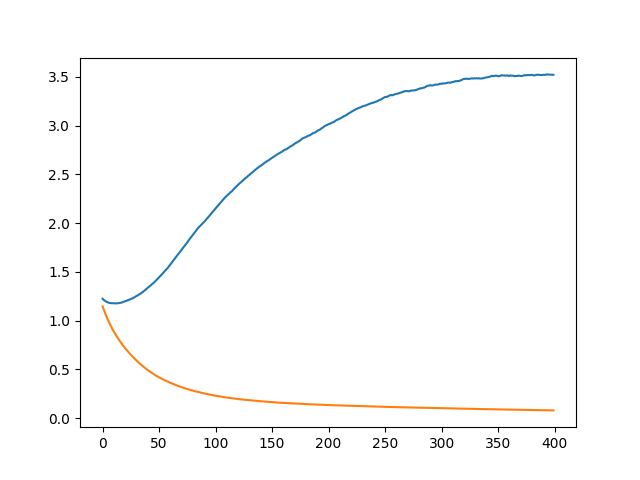

In [9]:
x = list(range(epoch))
vy = training.history['val_loss']
ty = training.history['loss']

plt.plot( x, vy )
plt.plot( x, ty )
plt.show()

